**AlphaZero** is a model-based DRL method, which means that it needs knowledge of the transition and/or the reward for the problem.

This algorithm became very popular due to its success in the game of Go. AlphaZero was designed to be used in specific two-player games:
* Two-player zero-sum game: it is a generalization of the control situation, where there are more than one agent, known as players. Namely, there must be two players. Zero-sum means that the gains of one player must be the losses of the other, i.e., the game model is of extreme competition. However, it is true that AlphaZero could also be adapted to control problems.
* The game must have perfect observability, which means that the state is known to the agent. This rules out poker, for instance, as there is no perfect observability (i.e., a player does not know the cards on the deck nor the cards of the other players).
* The game must have deterministic transitions, which means that given a state-action pair, the next state is known.
* The agent must know the model (i.e., the rules in a board game such as chess). This assumption was relaxed by its successor algorithm, MuZero.

Note that board games are an ideal environment to test AlphaZero: this code illustrates AlphaZero using tic-tac-toe.

The three key elements of AlphaZero are:
* A neural network, that predicts the optimal value and policy for a given state $(v,\pi)=f_{\theta}(s)$.
* Monte-Carlo Tree Search (MCTS). AlphaZero builds a tree where each node is a state of the problem, and each edge represents an action. Each edge (i.e., each state-action pair) stores four statistics: $N$ (number of times the state-action pair has been visited), $W$ (the total value of the state-action pair), $Q$ (the mean state-action value, i.e., $W/N$), and $P$ (prior probability of choosing action $a$ in state $s$).

 MCTS is used to obtain rollouts: for a given state $s$, choose an action $a$ following the Upper Confidence Tree (UCT) algorithm (which balances exploration and exploitation), and repeat the process until a leaf is reached. The leaf may be (1) a final state of the game (i.e., a player wins) or (2) a state not added to the tree yet. In the former case, set the value of the game to the result, and in the latter, to the predicted value of the neural network. Finally, propagate the results to all state-action pairs visited, updating $N$, $W$ and $Q$.

 Note that the number of rollouts is the *thinking time*: more rollouts mean better results.

* A replay memory to update the neural network. Each state-action pair obtained during MCTS is appended to a replay memory, which is used to train the neural network.

In a board game, AlphaZero plays against itself (self-play) and learns from scratch. Let us check that in this code!

First, let us import all the libraries needed.

In [1]:
import numpy as np
from collections import deque
import random
import time
import torch
import torch.nn as nn
import pickle
%matplotlib inline
import matplotlib.pyplot as plt

Now, let us create the Tic-tac-toe game. To do that, we define two classes: one for the game, and another for each state (i.e., each board position). Note the similitude to the control environments that we have used before: many of the methods are similar.

In [2]:
class Game:

    def __init__(self):
        self.currentPlayer = 1  # Player that moves
        self.gameState = GameState(np.array([0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int), 1)
        self.actionSpace = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int)
        self.pieces = {'1': 'X', '0': '-', '-1': 'O'}
        self.grid_shape = (3, 3)
        self.input_shape = (2, 3, 3)
        self.name = 'Tic-tac-toe'
        self.state_size = len(self.gameState.binary)
        self.action_size = len(self.actionSpace)

    def reset(self):
        self.gameState = GameState(np.array([0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int), 1)
        self.currentPlayer = 1
        return self.gameState

    def step(self, action):
        next_state, value, done = self.gameState.takeAction(action)
        self.gameState = next_state
        self.currentPlayer = -self.currentPlayer
        info = None
        return ((next_state, value, done, info))

    def identities(self, state, actionValues):
        identities = [(state, actionValues)]
        currentBoard = state.board
        currentAV = actionValues
        currentBoard = np.array([
            currentBoard[2], currentBoard[1], currentBoard[0]
            , currentBoard[5], currentBoard[4], currentBoard[3]
            , currentBoard[8], currentBoard[7], currentBoard[6]
        ])
        currentAV = np.array([
            currentAV[2], currentAV[1], currentAV[0]
            , currentAV[5], currentAV[4], currentAV[3]
            , currentAV[8], currentAV[7], currentAV[6]
        ])
        identities.append((GameState(currentBoard, state.playerTurn), currentAV))
        return identities


class GameState():
    def __init__(self, board, playerTurn):
        self.board = board
        self.pieces = {'1': 'X', '0': '-', '-1': 'O'}
        self.winners = [  # List of positions that end the game
            [0, 1, 2],
            [3, 4, 5],
            [6, 7, 8],
            [0, 3, 6],
            [1, 4, 7],
            [2, 5, 8],
            [0, 4, 8],
            [2, 4, 6],
        ]
        self.playerTurn = playerTurn
        self.binary = self._binary()  # Positions occupied by current player (1) and the adversary (-1)
        self.id = self._convertStateToId()
        self.allowedActions = self._allowedActions()  # Allowed actions are where board is not occupied!
        self.isEndGame = self._checkForEndGame()
        self.value = self._getValue()
        self.score = self._getScore()

    def _allowedActions(self):
        allowed = []
        for i in range(len(self.board)):  # Allowed actions are only the ones where board==0
            if self.board[i] == 0:
                allowed.append(i)
        return allowed

    def _binary(self):
        currentplayer_position = np.zeros(len(self.board), dtype=int)
        currentplayer_position[self.board == self.playerTurn] = 1
        other_position = np.zeros(len(self.board), dtype=int)
        other_position[self.board == -self.playerTurn] = 1
        position = np.append(currentplayer_position, other_position)
        return (position)

    def _convertStateToId(self):
        player1_position = np.zeros(len(self.board), dtype=int)
        player1_position[self.board == 1] = 1
        other_position = np.zeros(len(self.board), dtype=int)
        other_position[self.board == -1] = 1
        position = np.append(player1_position, other_position)
        id = ''.join(map(str, position))
        return id

    def _checkForEndGame(self):
        if np.count_nonzero(self.board) == 9:
            return 1  # All positions in the board are occupied
        for x, y, z in self.winners:
            if (self.board[x] + self.board[y] + self.board[z] == 3 * -self.playerTurn):
                return 1  # A player has won the game
        return 0

    def _getValue(self):
        # This is the value of the state for the current player
        # i.e. if the previous player played a winning move, you lose
        for x, y, z in self.winners:
            if (self.board[x] + self.board[y] + self.board[z] == 3 * -self.playerTurn):
                return (-1, -1, 1)
        return (0, 0, 0)

    def _getScore(self):
        tmp = self.value
        return (tmp[1], tmp[2])

    def takeAction(self, action):
        newBoard = np.array(self.board)
        newBoard[action] = self.playerTurn
        newState = GameState(newBoard, -self.playerTurn)
        value = 0
        done = 0
        if newState.isEndGame:
            value = newState.value[0]
            done = 1
        return (newState, value, done)


Now, let us create the replay memory: again, we will use a queue to store the experience vectors. Short-term memory is used to store experience vectors, which are later moved to the long-term memory for training. This architecture allows for parallel training: one process updates the short-term memory with samples, while another updates the neural network using the long-term memory. Note that this implementation is not parallel, but the memory structure would allow it.

In [3]:
class Memory:
    def __init__(self, memory_size):
        self.memory_size = memory_size
        self.ltmemory = deque(maxlen=self.memory_size)
        self.stmemory = deque(maxlen=self.memory_size)

    def commit_stmemory(self, identities, state, actionValues):
        for r in identities(state, actionValues):
            self.stmemory.append({
                'board': r[0].board
                , 'state': r[0]
                , 'id': r[0].id
                , 'AV': r[1]
                , 'playerTurn': r[0].playerTurn
            })

    def commit_ltmemory(self):
        for i in self.stmemory:
            self.ltmemory.append(i)
        self.clear_stmemory()

    def clear_stmemory(self):
        self.stmemory = deque(maxlen=self.memory_size)

Next, we create the two basic structures for our tree: the nodes and the edges, with the information that each one of them stores.

In [4]:
class mcNode():

    def __init__(self, state):
        self.state = state
        self.playerTurn = state.playerTurn
        self.id = state.id
        self.edges = []

    def isLeaf(self):  # Checks whether the node is a leaf or not
        if len(self.edges) > 0:
            return False
        else:
            return True


class mcEdge():

    def __init__(self, inNode, outNode, prior, action):
        self.id = inNode.state.id + '|' + outNode.state.id
        self.inNode = inNode
        self.outNode = outNode
        self.playerTurn = inNode.state.playerTurn
        self.action = action

        self.stats = {
            'N': 0,
            'W': 0,
            'Q': 0,
            'P': prior,
        }

And finally, we implement our MCTS method to obtain a rollout, whose two main methods are:
* The **moveToLeaf** method starts in the root node, and takes actions following UCT algorithm until a leaf node is found.
* The **backfill** method updates all the edge statistics for the edges in a rollout.

In [5]:
class mcMCTS():

    def __init__(self, root, cpuct, EPSILON, ALPHA):
        self.root = root
        self.tree = {}
        self.cpuct = cpuct
        self.addNode(root)
        self.EPSILON = EPSILON
        self.ALPHA = ALPHA  # Dirichlet noise parameter

    def __len__(self):
        return len(self.tree)

    def moveToLeaf(self):
        breadcrumbs = []
        currentNode = self.root
        done = 0
        value = 0
        while not currentNode.isLeaf():
            maxQU = -99999
            if currentNode == self.root:
                epsilon = self.EPSILON
                nu = np.random.dirichlet([self.ALPHA] * len(currentNode.edges))
            else:
                epsilon = 0
                nu = [0] * len(currentNode.edges)
            Nb = 0
            for action, edge in currentNode.edges:
                Nb = Nb + edge.stats['N']
            for idx, (action, edge) in enumerate(currentNode.edges):
                U = self.cpuct * \
                    ((1 - epsilon) * edge.stats['P'] + epsilon * nu[idx]) * \
                    np.sqrt(Nb) / (1 + edge.stats['N'])
                Q = edge.stats['Q']
                if Q + U > maxQU:
                    maxQU = Q + U
                    simulationAction = action
                    simulationEdge = edge
            newState, value, done = currentNode.state.takeAction(simulationAction)  # the value of the newState from the POV of the new playerTurn
            currentNode = simulationEdge.outNode
            breadcrumbs.append(simulationEdge)
        return currentNode, value, done, breadcrumbs

    def backFill(self, leaf, value, breadcrumbs):
        currentPlayer = leaf.state.playerTurn
        for edge in breadcrumbs:
            playerTurn = edge.playerTurn
            if playerTurn == currentPlayer:
                direction = 1
            else:
                direction = -1
            edge.stats['N'] = edge.stats['N'] + 1
            edge.stats['W'] = edge.stats['W'] + value * direction
            edge.stats['Q'] = edge.stats['W'] / edge.stats['N']

    def addNode(self, node):
        self.tree[node.id] = node


Now, we define the neural network model that we are using. As Tic-tac-toe is a simple game, we simply use an MLP, which takes as input the state (i.e., board positions) and returns as output the value and the probability of each action.

In [6]:
class Gen_Model(nn.Module):  # Simple model for AlphaZero: an MLP
    def __init__(self, input_dim, output_dim, hidden_dim):
        super(Gen_Model, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.hidden_dim = hidden_dim
        # Prepare all the layers needed
        self.l1 = nn.Linear(self.input_dim, self.hidden_dim)
        self.l2 = nn.Linear(self.hidden_dim, self.hidden_dim)
        self.l3 = nn.Linear(self.hidden_dim, self.hidden_dim)
        self.l1_policy = nn.Linear(self.hidden_dim, self.output_dim)
        self.l1_value = nn.Linear(self.hidden_dim, 1)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        # Define forward pass
        x = self.relu(self.l1(x))
        x = self.relu(self.l2(x))
        x = self.relu(self.l3(x))
        logits = self.l1_policy(x)
        probs = self.softmax(logits)
        value = self.l1_value(x)
        return value, logits


Now, we are finally ready to create our AlphaZero agent, that implements the main algorithm.

In [7]:
class Agent():  # Alpha-Zero agent
    def __init__(self, name, state_size, action_size, model,
                 mcts_simulations=20,  # MCTS simulations: higher is better, but higher computational cost
                 cpuct=1,  # Exploration parameter: higher encourages exploration, but lower exploitation
                 epsilon=0.2,  # Epsilon value on UCT: higher encourages exploration, but lower exploitation
                 alpha=0.8,  # Dirichlet noise parameter value
                 training_loops=100,  # Number of batch sampled and trained per training call
                 epochs=5,  # Training epochs for a given batch
                 batch_size=128,  # Batch size
                 device=None  # Device to use for training
                 ):
        self.name = name
        self.state_size = state_size
        self.action_size = action_size
        self.cpuct = cpuct
        self.MCTSsimulations = mcts_simulations
        self.model = model
        self.mcts = None
        self.train_overall_loss = []
        self.train_value_loss = []
        self.train_policy_loss = []
        self.val_overall_loss = []
        self.val_value_loss = []
        self.val_policy_loss = []
        self.epsilon = epsilon
        self.alpha = alpha
        self.training_loops = training_loops
        self.epochs = epochs
        self.batch_size = batch_size
        if device is None:
            self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # To use GPU if available
        else:
            self.device = device
        print('AlphaZero is using device: ', self.device)
        # Prepare the optimizer
        self.learning_rate = 0.001
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=self.learning_rate)


    def simulate(self):
        leaf, value, done, breadcrumbs = self.mcts.moveToLeaf()  # Move to leaf
        value, breadcrumbs = self.evaluateLeaf(leaf, value, done, breadcrumbs)  # Evaluate the leaf
        self.mcts.backFill(leaf, value, breadcrumbs)  # Backfill the value through the tree

    def act(self, state, tau):
        if self.mcts == None or state.id not in self.mcts.tree:
            self.buildMCTS(state)
        else:
            self.changeRootMCTS(state)
        #### run the simulation
        for sim in range(self.MCTSsimulations):
            self.simulate()
        #### get action values
        pi, values = self.getAV(1)
        ####pick the action
        action, value = self.chooseAction(pi, values, tau)
        nextState, _, _ = state.takeAction(action)
        NN_value = -self.get_preds(nextState)[0]
        return (action, pi, value, NN_value)

    def predict(self, state):  # Note that this method works only for single states!
        preds = self.model(torch.unsqueeze(torch.from_numpy(state).type(torch.float32).to(self.device), 0))
        return preds[0].detach().cpu().numpy()[0], preds[1].detach().cpu().numpy()[0]

    def get_preds(self, state):
        # predict the leaf
        preds = self.predict(state.binary)
        value, logits = preds[0], preds[1]
        allowedActions = state.allowedActions
        mask = np.ones(logits.shape, dtype=bool)
        mask[allowedActions] = False
        logits[mask] = -100
        # SOFTMAX
        odds = np.exp(logits)
        probs = odds / np.sum(odds)
        return ((value, probs, allowedActions))

    def evaluateLeaf(self, leaf, value, done, breadcrumbs):
        if done == 0:
            value, probs, allowedActions = self.get_preds(leaf.state)
            probs = probs[allowedActions]
            for idx, action in enumerate(allowedActions):
                newState, _, _ = leaf.state.takeAction(action)
                if newState.id not in self.mcts.tree:
                    node = mcNode(newState)
                    self.mcts.addNode(node)
                else:
                    node = self.mcts.tree[newState.id]
                newEdge = mcEdge(leaf, node, probs[idx], action)
                leaf.edges.append((action, newEdge))
        return ((value, breadcrumbs))

    def getAV(self, tau):
        edges = self.mcts.root.edges
        pi = np.zeros(self.action_size, dtype=int)
        values = np.zeros(self.action_size, dtype=np.float32)
        for action, edge in edges:
            pi[action] = pow(edge.stats['N'], 1 / tau)
            values[action] = edge.stats['Q']
        pi = pi / (np.sum(pi) * 1.0)
        return pi, values

    def chooseAction(self, pi, values, tau):
        if tau == 0:
            actions = np.argwhere(pi == max(pi))
            action = random.choice(actions)[0]
        else:
            action_idx = np.random.multinomial(1, pi)
            action = np.where(action_idx == 1)[0][0]
        value = values[action]
        return action, value

    def replay(self, ltmemory):
        for i in range(self.training_loops):
            minibatch = random.sample(ltmemory, min(self.batch_size, len(ltmemory)))
            training_states = np.array([row['state'].binary for row in minibatch])
            value_target = np.array([row['value'] for row in minibatch])
            policy_target = np.array([row['AV'] for row in minibatch])
            # Train the model
            self.model.train()
            training_states = torch.from_numpy(training_states).type(torch.float32).to(self.device)
            value_target = torch.from_numpy(value_target).type(torch.float32).to(self.device)
            policy_target = torch.from_numpy(policy_target).type(torch.float32).to(self.device)

            for e in range(self.epochs):
                value, logits = self.model(training_states)
                value_loss = torch.mean(torch.square(value_target - value))
                policy_criterion = nn.CrossEntropyLoss()
                logits[policy_target == 0] = -100
                policy_loss = policy_criterion(logits, policy_target)
                loss = value_loss + policy_loss
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()

            self.train_overall_loss.append(round(loss.item(), 4))
            self.train_value_loss.append(round(value_loss.item(), 4))
            self.train_policy_loss.append(round(policy_loss.item(), 4))

    def buildMCTS(self, state):
        self.root = mcNode(state)
        self.mcts = mcMCTS(self.root, self.cpuct, self.epsilon, self.alpha)

    def changeRootMCTS(self, state):
        self.mcts.root = self.mcts.tree[state.id]


The next method is used to play a match between two agents. This allows us to train AlphaZero against itself, to test it against an optimal agent, and even allows you to play against AlphaZero!

In [8]:
def playMatches(player1, player2, EPISODES, turns_until_tau0, memory=None, goes_first=0):
    env = Game()
    scores = {player1.name: 0, "drawn": 0, player2.name: 0}
    sp_scores = {'sp': 0, "drawn": 0, 'nsp': 0}
    points = {player1.name: [], player2.name: []}
    for e in range(EPISODES):
        #print(str(e + 1) + ' ', end='')
        state = env.reset()
        done = 0
        turn = 0
        player1.mcts = None
        player2.mcts = None
        if goes_first == 0:
            player1Starts = random.randint(0, 1) * 2 - 1
        else:
            player1Starts = goes_first
        if player1Starts == 1:
            players = {1: {"agent": player1, "name": player1.name}
                , -1: {"agent": player2, "name": player2.name}
                       }
        else:
            players = {1: {"agent": player2, "name": player2.name}
                , -1: {"agent": player1, "name": player1.name}
                       }
        while done == 0:
            turn = turn + 1
            #### Run the MCTS algo and return an action
            if turn < turns_until_tau0:
                action, pi, MCTS_value, NN_value = players[state.playerTurn]['agent'].act(state, 1)
            else:
                action, pi, MCTS_value, NN_value = players[state.playerTurn]['agent'].act(state, 0)

            if memory != None:
                ####Commit the move to memory
                memory.commit_stmemory(env.identities, state, pi)
            ### Do the action
            state, value, done, _ = env.step(
                action)  # the value of the newState from the POV of the new playerTurn i.e. -1 if the previous player played a winning move
            if done == 1:
                if memory != None:
                    #### If the game is finished, assign the values correctly to the game moves
                    for move in memory.stmemory:
                        if move['playerTurn'] == state.playerTurn:
                            move['value'] = value
                        else:
                            move['value'] = -value
                    memory.commit_ltmemory()
                if value == 1:
                    # logger.info('%s WINS!', players[state.playerTurn]['name'])
                    scores[players[state.playerTurn]['name']] = scores[players[state.playerTurn]['name']] + 1
                    if state.playerTurn == 1:
                        sp_scores['sp'] = sp_scores['sp'] + 1
                    else:
                        sp_scores['nsp'] = sp_scores['nsp'] + 1
                elif value == -1:
                    # logger.info('%s WINS!', players[-state.playerTurn]['name'])
                    scores[players[-state.playerTurn]['name']] = scores[players[-state.playerTurn]['name']] + 1

                    if state.playerTurn == 1:
                        sp_scores['nsp'] = sp_scores['nsp'] + 1
                    else:
                        sp_scores['sp'] = sp_scores['sp'] + 1
                else:
                    # logger.info('DRAW...')
                    scores['drawn'] = scores['drawn'] + 1
                    sp_scores['drawn'] = sp_scores['drawn'] + 1
                pts = state.score
                points[players[state.playerTurn]['name']].append(pts[0])
                points[players[-state.playerTurn]['name']].append(pts[1])
    return (scores, memory, points, sp_scores)

We also use an optimal agent to track the performance of AlphaZero. Note that this agent is **not** used to train AlphaZero, as AlphaZero learns against itself: it is only used to *test* the performance of AlphaZero.

The *wget* command is used to download the trained agent from the internet.

In [9]:
!wget https://github.com/jparras/drl_classes/raw/main/model_based/oa.zip
!unzip /content/oa.zip
class Opt_agent():  # Optimal policy obtained (trained using min-max Q-Learning)
    def __init__(self, name, state_size, action_size):
        self.name = name
        self.state_size = state_size
        self.action_size = action_size
        try:
            #self.state_list = np.load('/content/alphazero_states.npy')
            #self.pi = np.load('/content/alphazero_pi.npy', allow_pickle=True)
            with open('/content/oa.pickle', 'rb') as handle:
              b = pickle.load(handle)
            self.state_list = b['states']
            self.pi = b['pi']
            print("Optimal agent loaded")
        except:
            print("Optimal agent couldn't be loaded")

    def act(self, state, tau):
        bd = np.copy(state.board)
        player = state.playerTurn  # Player that opt agent plays for
        bd[bd == -player] = 2
        bd[bd == player] = 1
        si = np.where(np.all(bd == self.state_list, 1))[0][0]
        if type(self.pi[
                    si]) is np.ndarray:  # In some states, the optimal policy is not unique (i.e., some actions lead to the highest possible reward)
            action = np.random.choice(self.pi[si])
        else:
            action = self.pi[si]
        pi = np.zeros(self.action_size)
        pi[action] = 1
        value = None
        NN_value = None
        return (action, pi, value, NN_value)

--2023-07-26 09:51:01--  https://github.com/jparras/drl_classes/raw/main/model_based/oa.zip
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/jparras/drl_classes/main/model_based/oa.zip [following]
--2023-07-26 09:51:01--  https://raw.githubusercontent.com/jparras/drl_classes/main/model_based/oa.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 40429 (39K) [application/zip]
Saving to: ‘oa.zip’

oa.zip              100%[===================>]  39.48K  --.-KB/s    in 0.003s  

2023-07-26 09:51:01 (13.3 MB/s) - ‘oa.zip’ saved [40429/40429]

Archive:  /content/oa.zip
  inflating: oa.pickle           

As usual, we seed everything for reproducibility.

In [10]:
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

And now it is time to finally train our model! Here is the main loop, which trains our AlphaZero agent from scratch

In [11]:
# Self play parameters
episodes = 50  # Number of games to self-play per iteration
turns_until_tau0 = 4  # turn on which it starts playing deterministically (to enforce exploration)
max_num_iter_train = 10  # Number of iterations to train Alpha Zero agent (increasing it improves results, at the cost of a higher training time)
matches_eval = 30
matches_final_eval = 100

# Start environment of the game
env = Game()
model = Gen_Model(input_dim=2 * np.prod(env.grid_shape), output_dim=env.action_size, hidden_dim=128) # Initialize Neural Network: input is the board state for both players
memory = Memory(memory_size=10000)  # Initialize memory
agent = Agent('AlphaZero', env.state_size, env.action_size, model, device='cpu')  # Create the agent
opt_player = Opt_agent('player_opt', env.state_size, env.action_size)  # Optimal player (to see the Alpha Zero agent evolution)
iteration = 0
scores_training = []
init_time = time.time()

while iteration < max_num_iter_train:
    iteration += 1
    t_iter = time.time()
    print('ITERATION ', iteration)

    # Self-play
    t = time.time()
    _, memory, _, _ = playMatches(agent, agent, episodes, turns_until_tau0=turns_until_tau0, memory=memory)
    memory.clear_stmemory()
    time_self_play = time.time() - t
    # Train neural network
    t = time.time()
    agent.replay(memory.ltmemory)
    #memory_samp = random.sample(memory.ltmemory, min(1000, len(memory.ltmemory)))
    time_train = time.time() - t
    # Evaluate performance
    t = time.time()
    scoresoa, _, _, _ = playMatches(opt_player, agent, matches_eval, turns_until_tau0=0, memory=None) # Check the performance level against the Optimal agent on 30 matches
    time_matches = time.time() - t
    scores_training.append(scoresoa)
    print('Iteration time:{} (self-play: {}, train: {}, evaluate: {}. Scores:{})' .format(time.time() - t_iter, time_self_play, time_train, time_matches, scoresoa))
print('TOTAL TRAINING TIME ', time.time() - init_time, ' seconds')

AlphaZero is using device:  cpu
Optimal agent loaded
ITERATION  1
Iteration time:22.98396611213684 (self-play: 19.119601488113403, train: 1.555994987487793, evaluate: 2.3066368103027344. Scores:{'player_opt': 16, 'drawn': 14, 'AlphaZero': 0})
ITERATION  2
Iteration time:12.45282530784607 (self-play: 8.672216892242432, train: 1.4899101257324219, evaluate: 2.290660858154297. Scores:{'player_opt': 15, 'drawn': 15, 'AlphaZero': 0})
ITERATION  3
Iteration time:12.573212385177612 (self-play: 8.609990358352661, train: 1.5270159244537354, evaluate: 2.4361655712127686. Scores:{'player_opt': 13, 'drawn': 17, 'AlphaZero': 0})
ITERATION  4
Iteration time:12.757163524627686 (self-play: 8.86455249786377, train: 1.5602376461029053, evaluate: 2.3323161602020264. Scores:{'player_opt': 13, 'drawn': 17, 'AlphaZero': 0})
ITERATION  5
Iteration time:16.02734661102295 (self-play: 8.850415229797363, train: 1.5765130519866943, evaluate: 5.60038161277771. Scores:{'player_opt': 13, 'drawn': 17, 'AlphaZero': 0})

After training, we now test our agent agains the optimal one, and see how it performs. Also, we show the training curve, which is simply the proportion of victories against the optimal agent. In tic-tac-toe, the optimal agent always draws, so do not expect AlphaZero to win agains the optimal agent!

FINAL TOURNAMENT AGAINST OA...

SCORES
{'player_opt': 47, 'drawn': 53, 'AlphaZero': 0}





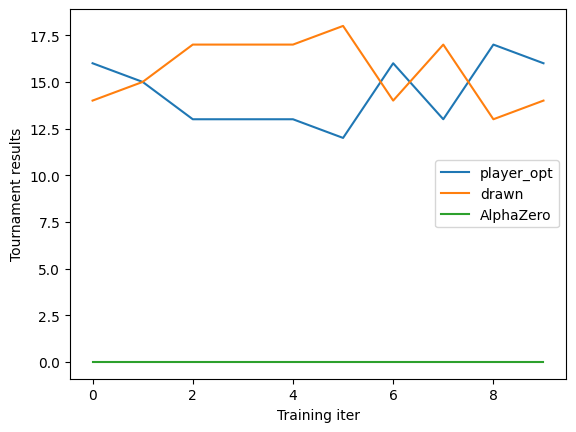

In [12]:
print('FINAL TOURNAMENT AGAINST OA...')
scoresoa_final, _, pointsoa_final, sp_scoresoa_final = playMatches(opt_player, agent, matches_final_eval, turns_until_tau0=0, memory=None)
print('\nSCORES')
print(scoresoa_final)
print('\n\n')
for label in ['player_opt', 'drawn', 'AlphaZero']:
  plt.plot([s[label] for s in scores_training], label=label)
plt.xlabel('Training iter')
plt.ylabel('Tournament results')
plt.legend(loc='best')
plt.show()

And finally, why don't you test yourself against AlphaZero? We now create a *User* agent, that we use to play agains AlphaZero using the command line. Good luck!

In [13]:
def print_tic_tac_toe(values): # Method to print the game
    print("\n")
    print("\t     |     |")
    print("\t  {}  |  {}  |  {}".format(values[0], values[1], values[2]))
    print('\t_____|_____|_____')

    print("\t     |     |")
    print("\t  {}  |  {}  |  {}".format(values[3], values[4], values[5]))
    print('\t_____|_____|_____')

    print("\t     |     |")

    print("\t  {}  |  {}  |  {}".format(values[6], values[7], values[8]))
    print("\t     |     |")
    print("\n")

class User():  # A class to play against any player using the command line
    def __init__(self, name, state_size, action_size):
        self.name = name
        self.state_size = state_size
        self.action_size = action_size

    def act(self, state, tau):
        values = [state.pieces[str(i)] for i in list(state.board)]
        print_tic_tac_toe(values)
        print('Your pieces are ', state.pieces[str(state.playerTurn)], ' and your opponent pieces are ', state.pieces[str(-state.playerTurn)])
        action = int(input('Enter your chosen action (0-8): '))
        pi = np.zeros(self.action_size)
        pi[action] = 1
        value = None
        NN_value = None
        return (action, pi, value, NN_value)

player1 = User('user', env.state_size, env.action_size)
# Select the player you wish to play against
player2 = opt_player  # Select this to play againts the optimal agent
player2 = agent  # Select this to play against the Alpha Zero agent
scores, _, _, _ = playMatches(player1, player2, 1, turns_until_tau0=0, memory=None)
print(scores)



	     |     |
	  -  |  -  |  -
	_____|_____|_____
	     |     |
	  -  |  -  |  -
	_____|_____|_____
	     |     |
	  -  |  -  |  -
	     |     |


Your pieces are  X  and your opponent pieces are  O
Enter your chosen action (0-8): 4


	     |     |
	  -  |  -  |  -
	_____|_____|_____
	     |     |
	  O  |  X  |  -
	_____|_____|_____
	     |     |
	  -  |  -  |  -
	     |     |


Your pieces are  X  and your opponent pieces are  O
Enter your chosen action (0-8): 0


	     |     |
	  X  |  -  |  -
	_____|_____|_____
	     |     |
	  O  |  X  |  -
	_____|_____|_____
	     |     |
	  -  |  -  |  O
	     |     |


Your pieces are  X  and your opponent pieces are  O
Enter your chosen action (0-8): 6


	     |     |
	  X  |  -  |  O
	_____|_____|_____
	     |     |
	  O  |  X  |  -
	_____|_____|_____
	     |     |
	  X  |  -  |  O
	     |     |


Your pieces are  X  and your opponent pieces are  O
Enter your chosen action (0-8): 5


	     |     |
	  X  |  -  |  O
	_____|_____|_____
	     | 